In [35]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from pathlib import Path

# Ignore Warnings - Not recommended, but looks nice.
import warnings
warnings.filterwarnings("ignore")

class Asset(object):

    def __init__(self, ticker: str, short_window=30, long_window=50, period="ytd", interval="1h"):
        
        """
        Class for backtesting of SMA-based trading strategies.
        
        :Attributes:
        ============
            ticker : str
                Valid tickers: Anything found on YFinance or American stock exchanges
                Examples: TSLA, NIO, F
            short_window : int
                Valid window: Anything less than the long window.
            long_window : int
                Valid window: Anything greater than the short window.
            period : str
                Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            interval : str
                Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            share size : int
                Default: 50
            initial capital : int
                Default: $10,000 (10000)
        """
    
        self.ticker = ticker
        self.short_window = short_window
        self.long_window = long_window
        self.period = period
        self.interval = interval
        self.share_size = 50
        self.initial_capital = 10000
        self.getDataFrame()

    def getDataFrame(self):
        
        """
        Creates a DataFrame of the asset with a short SMA, long SMA,
            cross over signals, and whether to enter or exit a trade.
            
        :Parameters:
        ============
            short_window : int
                Valid input: ints less than the size of the long_window
            long_window : int
                Valid input: ints greater than the size of the short_window
        """
        
        # Building DataFrame
        
        df = yf.Ticker(self.ticker).history(period=self.period, interval=self.interval)
        df['Return'] = np.log(df["Close"] / df["Close"].shift(1))
        df[f"SMA{self.short_window}"] = df["Close"].rolling(window=self.short_window).mean()
        df[f"SMA{self.long_window}"] = df["Close"].rolling(window=self.long_window).mean()
        df["Signal"] = 0.0
        
        # Clean DataFrame
        
        df.drop(columns=["Dividends","Stock Splits"], inplace=True)
        
        # Establish DataFrame as property
        
        self.df = df
        
    def runStrategy(self):
        
        """
         Backtests trading strategy
        """

        # DATA
        df = self.df.copy().dropna()
        
        # POSITION, 1 LONG, -1 SHORT
        df['Position'] = np.where(
            df[f"SMA{self.short_window}"] > df[f"SMA{self.long_window}"],
            1,
            -1
        )
        
        # SIGNAL TO ACTION, 1 for LONG ORDER, -1 SHORT ORDER
        df['Signal'] = df['Position'][df['Position'].diff() != 0]
        
        # RETURNS
        df['Strategy Returns'] = df['Position'].shift(1) * \
            df['Return']
        df['Cumulative Returns'] = self.initial_capital * \
            df['Return'].cumsum().apply(np.exp)
        df['Cumulative Strat Returns'] = self.initial_capital * \
            df['Strategy Returns'].cumsum().apply(np.exp)
        df['Signal'].fillna(0, inplace=True)
        
        # Drop first row of NaN data
        df.dropna(inplace=True)
        
        # results returns data DF
        self.results = df
        
        # Gross / Actual Performance
        stratPerformance = df['Cumulative Strat Returns'].iloc[-1]
        
        # Buy & Hold (Cumulative Returns)
        buyAndHold = df['Cumulative Returns'].iloc[-1]
        
        # Over or Under perform?
        stratDifference = stratPerformance - buyAndHold
        
        print(f"Strategy: {round(stratPerformance, 2)}.\nBuy and Hold: {round(buyAndHold, 2)}\nDifference: {round(stratDifference, 2)}")
        
        return round(stratPerformance, 2), round(stratDifference, 2)
        

    def plotReturns(self):
        
        """
         Plots the cumulative returns of the strategy vs buying and holding.
        """
        
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        
        title = "%s | Short SMA=%d, Long SMA=%d" % (self.ticker,
                                           self.short_window,
                                           self.long_window)
        self.results[["Cumulative Returns","Cumulative Strat Returns"]]\
            .plot(title=title,figsize=(10, 6))
        
    def plotCrossover(self):
        
        """
         Plots the short and long SMA windows next to the price of the asset.
        """
        
        if self.df is None:
            print("There is no data to plot. Run a strategy.")
            
        title = "%s | Short SMA=%d, Long SMA=%d" % (self.ticker,
                                                   self.short_window,
                                                   self.long_window)
        
        self.df[["Close",f"SMA{self.short_window}",f"SMA{self.long_window}"]]\
            .plot(title=title, figsize=(10,6))
        
    def getRatios(self):
        
        """
        Shows important financial ratios of asset
        """
        
        pass

    def getBackTest(self):
        
        """
        Shows backtesting information on asset and SMA trading strategy
        """
        
        pass

Strategy: 8978.49.
Buy and Hold: 8093.12
Difference: 885.37


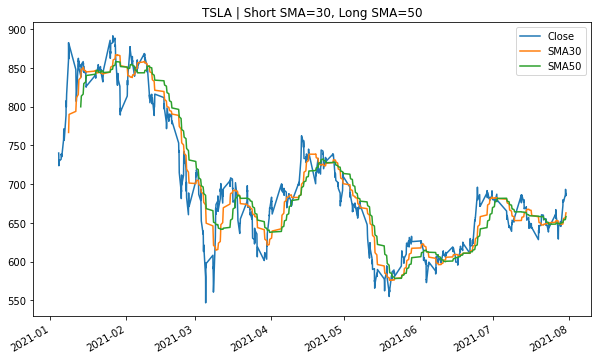

In [36]:
a = Asset(ticker="TSLA")
a.getDataFrame()
a.runStrategy()
a.plotCrossover()

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

def trading_signal(df, short_window, long_window, initial_capital, shares):
    
    ticker = str(df).split(".")[0]
    
    is_csv = Path(str(df)).suffix == ".csv"
    
    if is_csv == True:
        df = pd.read_csv(df, parse_dates=True, infer_datetime_format=True)
        df.columns = map(str.lower, df.columns)
        
        signals_df=df.loc[:, ["date", "close"]].copy()
    else:
        ticker = df["ticker"][0]
        signals_df=df.loc[:,["date","close"]].copy()
    
    # Signal Creation
    
    short_window = short_window
    long_window = long_window
    signals_df = signals_df.set_index("date", drop = True)
    signals_df["SMA_short"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA_long"] = signals_df["close"].rolling(window=long_window).mean()
    signals_df["Signal"] = 0.0

    # for short
    # When SMA_short < SMA_long, 0
    # when SMA_short > SMA_long, 1
    
    
    # for long 
    # When SMA_short > SMA_long, 0
    # when SMA_short < SMA_long, 1

    signals_df["Signal"][short_window:] = np.where(
    signals_df["SMA_short"][short_window:] < signals_df["SMA_long"][short_window:], 1, 0)
    signals_df["Entry/Exit"] = signals_df["Signal"].diff()
    signals_df_ = signals_df.copy()
    
    # Plotting Entry & Exit
    
    exit = signals_df[signals_df["Entry/Exit"] == -1.0]["close"].hvplot.scatter(
        color = "red",
        marker = "v",
        size = 200,
        legend= False,
        ylabel = "Price in $",
        width = 1000,
        height = 400    
    )
    
    entry = signals_df[signals_df["Entry/Exit"] == 1.0]["close"].hvplot.scatter(
        color = "green",
        marker = "^",
        size = 200,
        legend= False,
        ylabel = "Price in $",
        width = 1000,
        height = 400    
    )
    
    security_close = signals_df[["close"]].hvplot(
    line_color = "lightgray",
        ylabel = "Price in $",
        width = 1000,
        height = 400
    )
    
    moving_avgs = signals_df[["SMA_short", "SMA_long"]].hvplot(
        ylabel = "Price in $",
        width = 1000,
        height = 400
    )
    
    entry_exit_plot = security_close * moving_avgs * entry * exit
    entry_exit_plot = entry_exit_plot.opts(xaxis = None)
    
    # Backtesting
    
    initial_capital = float(initial_capital)
    share_size = shares
    
    signals_df["Position"] = share_size * signals_df["Signal"]
    signals_df["Entry/Exit Position"] = signals_df["Position"].diff()
    signals_df["Portfolio Holdings"] = signals_df["close"] * signals_df["Entry/Exit Position"].cumsum()
    signals_df["Portfolio Cash"] = initial_capital - (signals_df["close"] * signals_df["Entry/Exit Position"]).cumsum()
    signals_df["Portfolio Total"] = signals_df["Portfolio Cash"] + signals_df["Portfolio Holdings"]
    signals_df["Portfolio Daily Returns"] = signals_df["Portfolio Total"].pct_change()
    signals_df["Portfolio Cumulative Returns"] = (1+signals_df["Portfolio Daily Returns"]).cumprod() - 1
    
    backtesting = signals_df
    
    
    
    ## Portfolio Entry & Exit point
    
    exit = signals_df[signals_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
        color = "red",
        legend= False,
        ylabel = "Total Portfolio Value",
        width = 1000,
        height = 400    
    )
    
    entry = signals_df[signals_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
        color = "green",
        legend= False,
        ylabel = "Total Portfolio Value",
        width = 1000,
        height = 400    
    )
    
    total_portfolio_value = signals_df[["Portfolio Total"]].hvplot(
    line_color = "lightgray",
        ylabel = "Total Portfolio Value",
        width = 1000,
        height = 400    
    )
    
    portfolio_entry_exit_plot = total_portfolio_value * entry * exit
    portfolio_entry_exit_plot = portfolio_entry_exit_plot.opts(xaxis = None)
    
    # Portfolio Evaluation
    
    # Prepare DataFrame for metrics
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']
    columns = ['Backtest']

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
    
    # Calculate cumulative return
    portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
    
    # Calculate annualized return
    portfolio_evaluation_df.loc['Annual Return'] = (signals_df['Portfolio Daily Returns'].mean() * 252)
    
    # Calculate annual volatility
    portfolio_evaluation_df.loc['Annual Volatility'] = (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
    
    # Calculate Sharpe Ratio
    portfolio_evaluation_df.loc['Sharpe Ratio'] = (signals_df['Portfolio Daily Returns'].mean() * 252) / (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
    
    # Calculate Downside Return
    sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
    sortino_ratio_df.loc[:,'Downside Returns'] = 0
    target = 0
    mask = sortino_ratio_df['Portfolio Daily Returns'] < target
    sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
    
    
    # Calculate Sortino Ratio
    down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
    expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
    sortino_ratio = expected_return/down_stdev
    portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
    
    
    # trade evaluation
        # Initialize trade evaluation DataFrame with columns
    trade_evaluation_df = pd.DataFrame(
        columns=[
            'Stock', 
            'Entry Date', 
            'Exit Date', 
            'Shares', 
            'Entry Share Price', 
            'Exit Share Price', 
            'Entry Portfolio Holding', 
            'Exit Portfolio Holding', 
            'Profit/Loss']
    )

    # Per-trade evaluation metrics can also be calculated by iterating over the DataFrame containing backtested signal data 
    # Initialize iterative variables

    entry_date = ''
    exit_date = ''
    entry_portfolio_holding = 0
    exit_portfolio_holding = 0
    share_size = 0
    entry_share_price = 0
    exit_share_price = 0

    # Loop through signal DataFrame
    # If `Entry/Exit` is 1, set entry trade metrics
    # Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
    # Then append the record to the trade evaluation DataFrame

    for index, row in signals_df.iterrows():

        if row['Entry/Exit'] == 1:
            entry_date = index
            entry_portfolio_holding = row['Portfolio Holdings']
            share_size = row['Entry/Exit Position']
            entry_share_price = row['close']

        elif row['Entry/Exit'] == -1:
            exit_date = index
            exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
            exit_share_price = row['close']
            profit_loss = exit_portfolio_holding - entry_portfolio_holding
            trade_evaluation_df = trade_evaluation_df.append(
                {
                    'Stock': ticker,
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Shares': share_size,
                    'Entry Share Price': entry_share_price,
                    'Exit Share Price': exit_share_price,
                    'Entry Portfolio Holding': entry_portfolio_holding,
                    'Exit Portfolio Holding': exit_portfolio_holding,
                    'Profit/Loss': profit_loss
                },
                ignore_index=True)
    
    return signals_df_, entry_exit_plot, backtesting, portfolio_entry_exit_plot, portfolio_evaluation_df, trade_evaluation_df